In [ ]:
# default_exp dataset

In [ ]:
import os
import cv2
import random
import numpy as np
import torch
import torch.utils.data as data
from skimage.color import rgb2hsv, hsv2rgb
from skimage.transform import pyramid_gaussian

In [ ]:
# export
class Dataset(data.Dataset):
    # Seungjun's defaults for augmentations
    # https://github.com/SeungjunNah/DeepDeblur-PyTorch/blob/master/src/data/common.py
    def __init__(self, root_folder, image_pair_list, 
                 mode='train', 
                 augmentations={'hflip':0.5, 
                                'vflip':0.0, 
                                'rot90':0.5, 
                                'channel_shuffle':True, 
                                'saturation':True},
                 crop_size=256,
                 pyramid_scales=3):
        super(Dataset, self).__init__()
        
        self.mode = mode
        self.augmentations = augmentations
        self.crop_size = 256
        self.pyramid_scales = pyramid_scales
        input_list = []
        target_list = []
        with open(image_pair_list, 'r') as f:
            for line in f:
                input_filename = line.split(' ')[0].strip('\n').strip('\t')
                target_filename = line.split(' ')[1].strip('\n').strip('\t')
                input_filepath = os.path.join(root_folder, input_filename)
                target_filepath = os.path.join(root_folder, target_filename)
                input_list.append(input_filepath)
                target_list.append(target_filepath)
        self.input_list = input_list
        self.target_list = target_list
        assert len(self.input_list) == len(self.target_list)
        self.length = len(self.input_list)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        # remember that opencv has BGR order so read and convert
        input_ = cv2.imread(dataset.input_list[idx])[:,:,::-1]
        target = cv2.imread(dataset.target_list[idx])[:,:,::-1]
        
        # if testing, no nothing
        if self.mode=='test':
            pass
        else:
            H, W, C = input_.shape
            patch_y = random.randrange(0, H-self.crop_size+1)
            patch_x = random.randrange(0, W-self.crop_size+1)
            input_ = self.crop(input_, patch_x, patch_y)
            target = self.crop(target, patch_x, patch_y)
        
            # write all augmentations explicitly. why not?
            if random.random() < self.augmentations['hflip']:
                input_ = self.hflip(input_)
                target = self.hflip(target)
            if random.random() < self.augmentations['vflip']:
                input_ = self.vflip(input_)
                target = self.vflip(target)
            if random.random() < self.augmentations['rot90']:
                # clockwise/counter-clockwise
                if random.random() < 0.5:
                    input_ = self.vflip(input_)
                    target = self.vflip(target)
                input_ = self.rot90(input_)
                target = self.rot90(target)
            if self.augmentations['channel_shuffle']:
                # note that this is actually a lower probability
                # e.g. shuffled order may just be [0,1,2] again
                rgb_order = [0,1,2]
                random.shuffle(rgb_order)
                input_ = self.channel_shuffle(input_, rgb_order)
                target = self.channel_shuffle(target, rgb_order)            
            if self.augmentations['saturation']:
                # Seungjun's defaults
                modifier = random.uniform(0.5, 1.5)
                input_ = self.saturation(input_, modifier)
                target = self.saturation(target, modifier)
            # noise only for the input
            # remember the GAN diffaug thing, may help if noise addition is non-leaky?
            input_ = self.add_gaussian_noise(input_)
            
        # now generate a pyramid of images:
        input_ = input_.astype(np.float32)
        target = target.astype(np.float32)
        input_pyramid = list(pyramid_gaussian(input_, self.pyramid_scales-1, multichannel=True))
        target_pyramid = list(pyramid_gaussian(target, self.pyramid_scales-1, multichannel=True))
        
        # convert to tensors
        input_ = []
        target = []
        for scaled_input, scaled_target in zip(input_pyramid, target_pyramid):
            # ascontiguousarray is safer before tensor conversions
            scaled_input = np.ascontiguousarray(scaled_input.transpose(2, 0, 1))
            scaled_target = np.ascontiguousarray(scaled_target.transpose(2, 0, 1))
            input_.append(torch.from_numpy(scaled_input))
            target.append(torch.from_numpy(scaled_target))
        
        return {'input':input_,
                'target':target}
    '''
    AUGMENTATIONS
    '''            
    def add_gaussian_noise(self, img, sigma_sigma=2, rgb_range=255):    
        # TODO: note that this is highly unrealistic.
        # implement poisson. also a differentiable (pytorch?) version.
        # here is a discussion and scikit implementation of poisson
        # https://github.com/yu4u/noise2noise/issues/14
        '''
        image = input_
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        out = np.random.poisson(image * vals) / float(vals)
        out = np.clip(out, 0, 255).astype(np.uint8)
        '''
        # the default's are from Seungjun again
        # https://github.com/SeungjunNah/DeepDeblur-PyTorch/blob/master/src/data/common.py#L43
        sigma = np.random.normal() * sigma_sigma * rgb_range/255
        # I think casting to 32-bit here is redundant, but let's keep with Seungjun
        noise = np.random.randn(*img.shape).astype(np.float32) * sigma 
        return (img + noise).clip(0, rgb_range)
    
    def crop(self, img, patch_x, patch_y, crop_size=256):        
        # be careful about the patch location. it should be:
        # patch_y = random.randrange(0, H-patch_size+1)
        # patch_x = random.randrange(0, W-patch_size+1)
        return img[patch_y:patch_y+crop_size, patch_x:patch_x+crop_size, :]

    def hflip(self, img, p=0.5): 
        return img[:, ::-1, :]
    
    def vflip(self, img): 
        return img[::-1, :, :]

    def rot90(self, img): 
        return img.transpose(1, 0, 2)

    def channel_shuffle(self, img, rgb_order=[0,1,2]): 
        return img[..., rgb_order]

    def saturation(self, img, modifier=1.0, rgb_range=255):
        # slooooow.
        # TODO: maybe just use g(x)=αf(x)+β, i.e. contrast and brightness?
        # if not, maybe play with LAB space, it is slow anyway
        # TODO: try using cv2 instead of skimage
        # for now, I am keeping Seungjun's version
        hsv_img = rgb2hsv(img)
        hsv_img[..., 1] *= modifier
        return hsv2rgb(hsv_img).clip(0, 1) * rgb_range

# Sanity check

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
dataset = Dataset(root_folder='/storage/projects/all_datasets/GOPRO/train/', 
                  image_pair_list='/storage/projects/all_datasets/GOPRO/train/image_pair_list.txt')

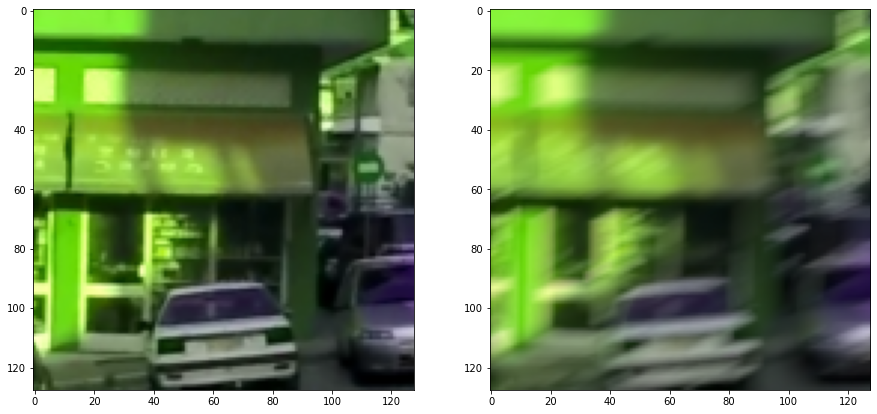

In [ ]:
sample = dataset[0]
target_image = sample['target'][1].numpy().transpose(1,2,0)/255
input_image = sample['input'][1].numpy().transpose(1,2,0)/255
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(target_image)
plt.subplot(122)
plt.imshow(input_image)

# Dataloader test

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import SequentialSampler, RandomSampler

In [ ]:
batch_size = 32
sampler = RandomSampler(dataset, replacement=False)
num_workers = 4
drop_last = True
loader = DataLoader(dataset=dataset,
                    batch_size=batch_size,
                    shuffle=False,
                    sampler=sampler,
                    num_workers=num_workers,
                    pin_memory=True,
                    drop_last=drop_last,
                   )

In [ ]:
for sample in loader:
    break

In [ ]:
random_in_batch = random.randint(0, batch_size-1)

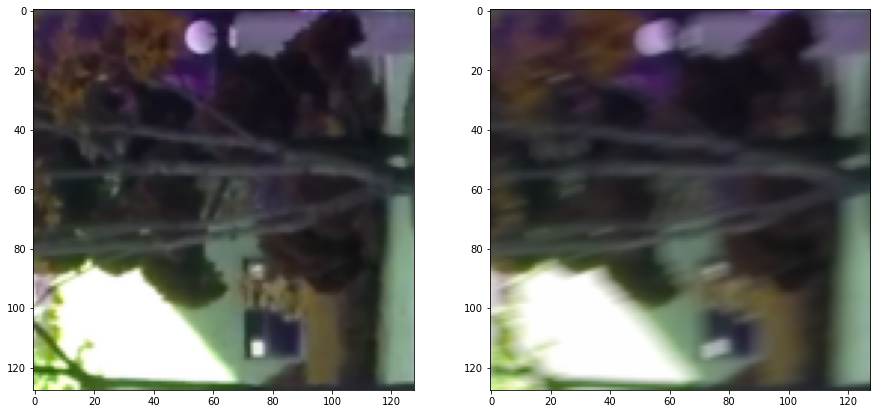

In [ ]:
target_image = sample['target'][1][random_in_batch].numpy().transpose(1,2,0)/255
input_image = sample['input'][1][random_in_batch].numpy().transpose(1,2,0)/255
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(target_image)
plt.subplot(122)
plt.imshow(input_image)

In [ ]:
from nbdev.export import *
notebook2script()

Converted 01_model.ipynb.
Converted 02_generators.ipynb.
Converted 03_discriminators.ipynb.
Converted 04_dataset.ipynb.
Converted 99_diffaugment.ipynb.
Converted Untitled.ipynb.
